In [1]:
from itertools import chain
from random import random

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from society.action import Action
from society.agent import Agent
from society.simulations.adaptive import AdaptiveSimulation
from society.agents.constant import AllC, AllD
from society.agents.qlearning import TabularQLearner, DoubleTabularQLearner
from society.agents.random import Random
from society.agents.tft import TitForTat
from society.visualisation.network import *

# plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.figsize"] = (12, 5)

In [2]:
# def generate_population(communities, size):
#     population = communities * size

#     agents = [
#         TabularQLearner(lookback=1, epsilon=0.1, learning_rate=0.05)
#         for i in range(population)
#     ]

#     G = nx.connected_caveman_graph(communities, size)

#     weights_matrix = np.zeros((population, population))
#     for u, v, d in G.edges(data=True):
#         weights_matrix[u, v] = weights_matrix[v, u] = 1
#         try:
#             d["weight"] = weights_matrix[u, v]
#         except:
#             d["weight"] = 0

#     return agents, weights_matrix, G

In [3]:
def generate_population(communities, size):
    population = communities * size

    agents = [
        DoubleTabularQLearner(
            lookback=2, epsilon=0.1, learning_rate=0.05, discount_factor=0.98
        )
        for i in range(population)
    ]

    G = nx.connected_caveman_graph(communities, size)

    # G = nx.Graph()
    # G.add_weighted_edges_from([
    #     (0, i, 1) for i in range(1, population)
    # ])

    weights_matrix = np.zeros((population, population))
    for u, v, d in G.edges(data=True):
        weights_matrix[u, v] = weights_matrix[v, u] = 1
        try:
            d["weight"] = weights_matrix[u, v]
        except:
            d["weight"] = 0

    return agents, weights_matrix, G

In [4]:
# _, _, G = generate_population(2, 16)

# nx.draw(G, pos=nx.spring_layout(G), font_color="white", with_labels=True)

In [5]:
def compute_policies(agents):
    policies = [
        agent._q_table.argmax(axis=-1) if hasattr(agent, "_q_table") else None
        for agent in agents
    ]

    return [
        "".join(
            [
                ("C", "D")[policy[i, j]]
                for i in range(4)
                for j in range(4)
                # for k in range(4)
            ]
        )
        if policy is not None
        else "OTHER"
        for policy in policies
    ]


def calculate_cooperativeness(history):
    count = history.count(Action.COOPERATE)

    return count / len(history)

In [6]:
PAYOFF_LABELS = ["(C, C)", "(C, D)", "(D, C)", "(D, D)"]
# PAYOFF_LABELS = ["R", "S", "T", "P"]

Run 1:   0%|          | 0/30000 [00:00<?, ?it/s]

BEST AGENT (139): 244600 (0.9204289188591642, DCCCDCCCDCCCCCCC)
WORST AGENT (5): 98386 (0.8589890745228075, CDCCCCCCCCCCCCCC)


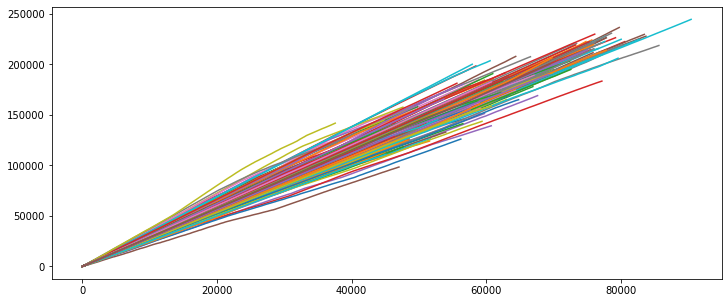

In [7]:
POPULATION = (64, 4)
ROUNDS = 30_000

run_rewards = []
run_cumulative_rewards = []
# run_action_histories = []
run_reward_histories = []
run_policies = []

for run in range(1):
    # Generate a new population
    agents, weights_matrix, G = generate_population(*POPULATION)

    # Run a number of rounds
    sim = AdaptiveSimulation(agents, weights_matrix)

    # Run the simulation
    sim.reset()
    for i in tqdm(range(ROUNDS), desc=f"Run {run + 1}"):
        sim.play_round(train=True)

    # Store results
    run_rewards.append(sim.rewards)
    # run_action_histories.append(sim.action_histories)
    run_reward_histories.append(sim.reward_histories)
    run_policies.append(compute_policies(agents))

    # Output statistics for the best and worst agents
    cumulative_rewards = [
        (i, sum(history)) for i, history in enumerate(sim.reward_histories)
    ]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    tqdm.write(
        f"BEST AGENT ({cumulative_rewards[0][0]}): {cumulative_rewards[0][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[0][0]])))}, {run_policies[-1][cumulative_rewards[0][0]]})"
    )
    tqdm.write(
        f"WORST AGENT ({cumulative_rewards[-1][0]}): {cumulative_rewards[-1][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[-1][0]])))}, {run_policies[-1][cumulative_rewards[-1][0]]})"
    )

    for rh in sim.reward_histories:
        plt.plot(np.cumsum(rh))

    plt.show()

In [8]:
# plot_matrix(sim.produce_weight_matrix(), digits=2, figsize=(60, 36))

In [9]:
# plot_matrix(sim.frequencies, digits=0, figsize=(60, 36))

In [10]:
sim.calculate_weights()

[array([0.26035327, 0.17475141, 0.17451531]),
 array([0.74946475, 0.78826779]),
 array([0.26035327, 0.74946475, 0.72250382]),
 array([0.17475141, 0.78826779, 0.72250382, 0.50752948]),
 array([0.50752948, 0.32796618, 0.28498046]),
 array([0.21190368, 0.28998192]),
 array([0.32796618, 0.21190368, 0.23749605]),
 array([0.28498046, 0.28998192, 0.23749605, 0.33124113]),
 array([0.33124113, 0.80851624, 0.7706421 ]),
 array([0.75276982, 0.69697621]),
 array([0.80851624, 0.75276982, 0.76029616]),
 array([0.7706421 , 0.69697621, 0.76029616, 0.26856955]),
 array([0.26856955, 0.28493775, 0.34760482]),
 array([0.79045013, 0.34974764]),
 array([0.28493775, 0.79045013, 0.34750352]),
 array([0.34760482, 0.34974764, 0.34750352, 0.36601428]),
 array([0.36601428, 0.77898521, 0.76846476]),
 array([0.80434254, 0.74765553]),
 array([0.77898521, 0.80434254, 0.79837179]),
 array([0.76846476, 0.74765553, 0.79837179, 0.47690448]),
 array([0.47690448, 0.29359943, 0.14425179]),
 array([0.3744044 , 0.57968769]),


In [11]:
sim.action_histories[0][2]

[<Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.DEFECT: 1>,
 

In [12]:
cumulative_rewards[0][0]

139

In [13]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    print(agents[cumulative_rewards[0][0]]._q_table)

[[[2.63467915e+02 2.63634252e+02]
  [2.64922260e+02 2.49929107e+02]
  [2.63587297e+02 2.51899378e+02]
  [2.62741324e+02 9.79829631e+01]]

 [[2.65090933e+02 2.65447188e+02]
  [2.66434746e+02 2.07209401e+02]
  [2.63444750e+02 9.16839953e+01]
  [2.20604640e+02 8.95206570e+00]]

 [[2.61503236e+02 2.63637722e+02]
  [2.66862542e+02 1.37493681e+02]
  [2.61952062e+02 5.75795194e+01]
  [7.21533431e+01 5.00000000e-02]]

 [[2.64693902e+02 1.91836907e+02]
  [2.61067629e+02 5.60620390e+01]
  [1.83303507e+02 1.95793758e+01]
  [2.43215379e+01 0.00000000e+00]]]


In [14]:
agents[cumulative_rewards[4][0]].play_move(
    [Action.COOPERATE, Action.COOPERATE], [Action.COOPERATE, Action.COOPERATE]
)

<Action.COOPERATE: 0>

In [15]:
agents[1]._q_table

array([[[253.92901196, 253.38111877],
        [255.17827647, 228.65188758],
        [252.16556549, 173.02980421],
        [218.16363602,   1.02364974]],

       [[255.61288855, 246.55513523],
        [ 41.21443111, 223.58537673],
        [247.47520313,  34.94244481],
        [ 77.49256624,   0.        ]],

       [[251.40712213, 207.95928896],
        [252.59740308,  43.5363782 ],
        [227.50191796,   6.29724232],
        [ 70.28022471,   0.        ]],

       [[250.56047091,  32.96921718],
        [ 73.15194619,   0.        ],
        [ 18.40024347,   0.        ],
        [  0.        ,   0.        ]]])

In [16]:
# from datetime import datetime
# import pickle

# with open(f"results - {datetime.isoformat(datetime.now()).replace(':', '-')}.pickle", "wb") as f:
#     pickle.dump({
#         "rewards": run_rewards,
#         "cumulative_rewards": run_cumulative_rewards,
#         # "action_histories": run_action_histories,
#         "reward_histories": run_reward_histories,
#         "policies": run_policies,
#     }, f)

In [17]:
cumulative_reward_policy_ranks = {}
cumulative_reward_policies = {}

for policies, reward_histories in zip(run_policies, run_reward_histories):
    cumulative_rewards = [
        (i, sum(history)) for i, history in enumerate(reward_histories)
    ]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    for rank, (i, cumulative_reward) in enumerate(cumulative_rewards):
        policy = policies[i]

        if policy not in cumulative_reward_policy_ranks:
            cumulative_reward_policy_ranks[policy] = []
            cumulative_reward_policies[policy] = []

        cumulative_reward_policy_ranks[policy].append(rank + 1)
        cumulative_reward_policies[policy].append(cumulative_reward)

mean_cumulative_reward_policy_ranks = {
    policy: np.mean(ranks) for policy, ranks in cumulative_reward_policy_ranks.items()
}
mean_cumulative_reward_policies = {
    policy: np.mean(rewards) for policy, rewards in cumulative_reward_policies.items()
}

In [18]:
for policy in sorted(
    mean_cumulative_reward_policy_ranks,
    key=lambda x: mean_cumulative_reward_policy_ranks[x],
):
    print(f"{mean_cumulative_reward_policy_ranks[policy]:<24} {policy}")

2.0                      DCCCCDCCDCCCCCCD
7.0                      DCCCDDCCDCCCDCCC
10.0                     DCCCCCCCCCCDCCCC
14.5                     CCCCDDCCCCCCCCCC
16.0                     DCCDCCCCCCCCCCCD
22.0                     CCCCCCCDCCCCCDCC
23.0                     CCDCCDCCCCCCCCCC
32.0                     DDCCCCDCCCCCCCCC
33.0                     DCCCDDCCCCCCDCCC
33.5                     DCCDCCCCCCCDCCCC
36.0                     DCCCDCCCDCCCCCDC
37.0                     CCCDCCCCCCCDCCCC
38.333333333333336       CCCCCCCCCCCCCCCD
48.0                     CCCCCDCCCCCCDCCC
49.0                     CDCCCDCCCCCCCDCC
50.0                     DDCCDCCDDCCCDDCC
52.0                     DDCDCCCCDCCCCCCC
53.0                     CDCCDCDCCCCCCCCC
54.0                     DCCDDCCCDCCCCDCC
55.0                     DDCCCDCCCDCCCDCC
56.0                     CCCCDCCCDCCCCCCC
57.0                     DCCCCDCCDCCCDCCC
59.0                     DCDCCDCCCCCCDCCC
64.66666666666667        DCCCDCCCD

In [19]:
for policy in sorted(
    mean_cumulative_reward_policies,
    key=lambda x: mean_cumulative_reward_policies[x],
    reverse=True,
):
    print(f"{mean_cumulative_reward_policies[policy]:<24} {policy}")

236565.0                 DCCCCDCCDCCCCCCD
227933.0                 DCCCDDCCDCCCDCCC
226307.0                 DCCCCCCCCCCDCCCC
223716.0                 CCCCDDCCCCCCCCCC
222599.0                 DCCDCCCCCCCCCCCD
222032.0                 CCCCCCCDCCCCCDCC
221683.0                 CCDCCDCCCCCCCCCC
219228.0                 DDCCCCDCCCCCCCCC
218732.0                 DCCCDDCCCCCCDCCC
215828.0                 DCCDCCCCCCCDCCCC
214694.0                 DCCCDCCCDCCCCCDC
214222.0                 CCCDCCCCCCCDCCCC
213625.0                 CCCCCCCCCCCCCCCD
209020.0                 CCCCCDCCCCCCDCCC
208196.0                 CDCCCDCCCCCCCDCC
207925.0                 DDCCDCCDDCCCDDCC
206489.0                 DDCDCCCCDCCCCCCC
206135.0                 CDCCDCDCCCCCCCCC
205675.0                 DCCDDCCCDCCCCDCC
205625.0                 DDCCCDCCCDCCCDCC
203617.0                 CCCCDCCCDCCCCCCC
203367.0                 DCCCCDCCDCCCDCCC
200760.0                 DCCCDCCCDCCCCCCC
200437.0                 DCDCCDCCC

In [20]:
compute_policies([agents[cumulative_rewards[0][0]]])[0]

'DCCCDCCCDCCCCCCC'

In [21]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    print(agents[cumulative_rewards[0][0]]._q_table)

[[[2.63467915e+02 2.63634252e+02]
  [2.64922260e+02 2.49929107e+02]
  [2.63587297e+02 2.51899378e+02]
  [2.62741324e+02 9.79829631e+01]]

 [[2.65090933e+02 2.65447188e+02]
  [2.66434746e+02 2.07209401e+02]
  [2.63444750e+02 9.16839953e+01]
  [2.20604640e+02 8.95206570e+00]]

 [[2.61503236e+02 2.63637722e+02]
  [2.66862542e+02 1.37493681e+02]
  [2.61952062e+02 5.75795194e+01]
  [7.21533431e+01 5.00000000e-02]]

 [[2.64693902e+02 1.91836907e+02]
  [2.61067629e+02 5.60620390e+01]
  [1.83303507e+02 1.95793758e+01]
  [2.43215379e+01 0.00000000e+00]]]


In [22]:
from itertools import product

P = compute_policies([agents[cumulative_rewards[0][0]]])[0]

for m, p in zip(product(PAYOFF_LABELS, PAYOFF_LABELS), P):
    print(m, "=>", p)

('(C, C)', '(C, C)') => D
('(C, C)', '(C, D)') => C
('(C, C)', '(D, C)') => C
('(C, C)', '(D, D)') => C
('(C, D)', '(C, C)') => D
('(C, D)', '(C, D)') => C
('(C, D)', '(D, C)') => C
('(C, D)', '(D, D)') => C
('(D, C)', '(C, C)') => D
('(D, C)', '(C, D)') => C
('(D, C)', '(D, C)') => C
('(D, C)', '(D, D)') => C
('(D, D)', '(C, C)') => C
('(D, D)', '(C, D)') => C
('(D, D)', '(D, C)') => C
('(D, D)', '(D, D)') => C
